In [63]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

""" DL imports """

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [64]:
ct_path = "/home/jtabalon/airway_seg/test_data/ct_patients10004O.nii"
aw_path = "/home/jtabalon/airway_seg/test_data/aw_10004O.nii"

img = nib.load(ct_path).get_fdata()
mask = nib.load(aw_path).get_fdata()

test_img = np.expand_dims(np.expand_dims(img, -1), 0)
test_mask = np.expand_dims(np.expand_dims(mask, -1), 0)

print(img.shape, mask.shape, type(img), type(mask))

(512, 512, 662) (512, 512, 662) <class 'numpy.memmap'> <class 'numpy.memmap'>


In [65]:
print(test_img.shape, test_mask.shape)

(1, 512, 512, 662, 1) (1, 512, 512, 662, 1)


In [66]:
# 0 -> patient
# 1 -> row
# 2 -> column
# 3 -> slice
# 4 -> channel

np.argmax(np.sum(test_mask, axis = (0,1,2,4)))

411

In [67]:
np.where(test_mask[0,:,:,411,0] > 0)

# in the 411th slice, these are all voxels which have a label of airway
# one to one correspondence of which voxels have airway

(array([291, 291, 291, 292, 292, 292, 292, 292, 293, 293, 293, 294, 294,
        294, 294, 294, 294, 294, 294, 295, 295, 295, 295, 295, 295, 295,
        296, 296, 296, 296, 296, 296, 297, 297, 297, 297, 297, 297, 298,
        298, 298, 298, 299, 299, 299, 299, 300, 300, 301, 301, 301, 302,
        302, 302, 303, 303, 303, 303, 303, 303, 303, 303, 303, 304, 304,
        304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304,
        304, 304, 304, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305,
        305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305,
        305, 305, 305, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306,
        306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306,
        306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306,
        306, 306, 306, 306, 306, 307, 307, 307, 307, 307, 307, 307, 307,
        307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307,
        307, 307, 307, 307, 307, 307, 307, 307, 307

In [68]:
# test_img[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:].shape 
# edit: wrong indexes bc of img

test_img[:,(291-32):(291+32),(170-32):(170+32),(411-32):(411+32),:].shape 
test_mask[:,(291-32):(291+32),(170-32):(170+32),(411-32):(411+32),:].shape 


(1, 64, 64, 64, 1)

# Data Generator

In [69]:
# TODO: Create Data Generator

# Model Creation

In [70]:
nb_enc_features = [32, 64, 64, 64]
nb_dec_features = [64, 64, 64, 64, 64, 32, 32]

In [71]:
# Hyperparameters

batch_size = 1  # from torch notebook
# learning_rate = 1e-2 # TODO change learning rate
learning_rate = 1e-5 # TODO change learning rate

In [72]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [73]:

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras import Input


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    print(pool1)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    print(pool2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    print(pool3)
    conv4 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)
    print(pool4)

    conv5 = Conv3D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv3D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv3D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = -1)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv3D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = -1)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv3D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = -1)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv3D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = -1)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)

    #model = Model(input = inputs, output = conv10)
    model = Model(inputs, conv10)
    
    # if(pretrained_weights):
    	# model.load_weights(pretrained_weights)

    return model

In [74]:
# We'll leave the default branch of the git repo as a dice_loss for now until we get actually training.
def dice_loss(y_true, y_pred):
    # y_true = tf.cast(y_true, tf.float32) note: can delete
    # y_pred = tf.math.sigmoid(y_pred) #is this necessary? note: can delete
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator

In [75]:
def compile_model(learning_rate):
    model.compile(optimizer = Adam(lr=learning_rate), loss = dice_loss)

Next steps: 
- create data generator

In [76]:
model = unet(input_size=(64,64,64, 1))
compile_model(learning_rate)

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 32, 64), dtype=tf.float32, name=None), name='max_pooling3d_12/MaxPool3D:0', description="created by layer 'max_pooling3d_12'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 16, 128), dtype=tf.float32, name=None), name='max_pooling3d_13/MaxPool3D:0', description="created by layer 'max_pooling3d_13'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 8, 256), dtype=tf.float32, name=None), name='max_pooling3d_14/MaxPool3D:0', description="created by layer 'max_pooling3d_14'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 4, 512), dtype=tf.float32, name=None), name='max_pooling3d_15/MaxPool3D:0', description="created by layer 'max_pooling3d_15'")


In [77]:
for layer in model.layers:
    print(layer.output_shape)

[(None, 64, 64, 64, 1)]
(None, 64, 64, 64, 64)
(None, 64, 64, 64, 64)
(None, 32, 32, 32, 64)
(None, 32, 32, 32, 128)
(None, 32, 32, 32, 128)
(None, 16, 16, 16, 128)
(None, 16, 16, 16, 256)
(None, 16, 16, 16, 256)
(None, 8, 8, 8, 256)
(None, 8, 8, 8, 512)
(None, 8, 8, 8, 512)
(None, 8, 8, 8, 512)
(None, 4, 4, 4, 512)
(None, 4, 4, 4, 1024)
(None, 4, 4, 4, 1024)
(None, 4, 4, 4, 1024)
(None, 8, 8, 8, 1024)
(None, 8, 8, 8, 512)
(None, 8, 8, 8, 1024)
(None, 8, 8, 8, 512)
(None, 8, 8, 8, 512)
(None, 16, 16, 16, 512)
(None, 16, 16, 16, 256)
(None, 16, 16, 16, 512)
(None, 16, 16, 16, 256)
(None, 16, 16, 16, 256)
(None, 32, 32, 32, 256)
(None, 32, 32, 32, 128)
(None, 32, 32, 32, 256)
(None, 32, 32, 32, 128)
(None, 32, 32, 32, 128)
(None, 64, 64, 64, 128)
(None, 64, 64, 64, 64)
(None, 64, 64, 64, 128)
(None, 64, 64, 64, 64)
(None, 64, 64, 64, 64)
(None, 64, 64, 64, 2)
(None, 64, 64, 64, 1)


In [78]:
model.input

<KerasTensor: shape=(None, 64, 64, 64, 1) dtype=float32 (created by layer 'input_4')>

In [79]:
model.output

<KerasTensor: shape=(None, 64, 64, 64, 1) dtype=float32 (created by layer 'conv3d_95')>

In [80]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 64,  0                                            
__________________________________________________________________________________________________
conv3d_72 (Conv3D)              (None, 64, 64, 64, 6 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv3d_73 (Conv3D)              (None, 64, 64, 64, 6 110656      conv3d_72[0][0]                  
__________________________________________________________________________________________________
max_pooling3d_12 (MaxPooling3D) (None, 32, 32, 32, 6 0           conv3d_73[0][0]                  
____________________________________________________________________________________________

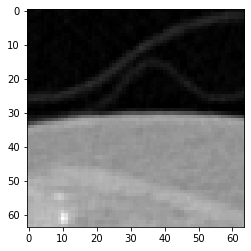

In [81]:
plt.imshow(test_img[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:][0,:,:,32,0], cmap = "gray")

In [82]:
test_image_slices = test_img[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:][0,:,:,32,0]
test_mask_slices = test_mask[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:]

In [83]:
real_test_image_slices = test_img[:,(291-32):(291+32),(170-32):(170+32),(411-32):(411+32),:] / 2000
real_test_mask_slices = test_mask[:,(291-32):(291+32),(170-32):(170+32),(411-32):(411+32),:] 

(array([111354.,  65558.,  12123.,   7268.,   5937.,   5298.,   6483.,
         18602.,  28887.,    634.]),
 array([-0.512 , -0.4475, -0.383 , -0.3185, -0.254 , -0.1895, -0.125 ,
        -0.0605,  0.004 ,  0.0685,  0.133 ]),
 <BarContainer object of 10 artists>)

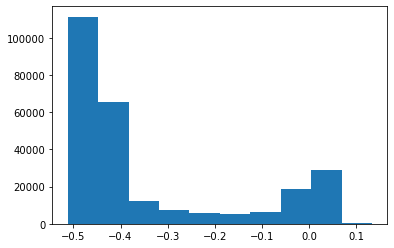

In [84]:
plt.hist(real_test_image_slices.flatten())

(array([259694.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   2450.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

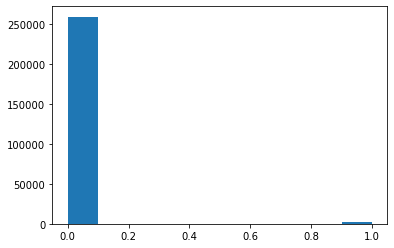

In [85]:
plt.hist(real_test_mask_slices.flatten())

When training with image -> divide by 2000

(array([1770.,  199.,   21.,   29.,   17.,  902., 1026.,  123.,    6.,
           3.]),
 array([-1024. ,  -868.1,  -712.2,  -556.3,  -400.4,  -244.5,   -88.6,
           67.3,   223.2,   379.1,   535. ]),
 <BarContainer object of 10 artists>)

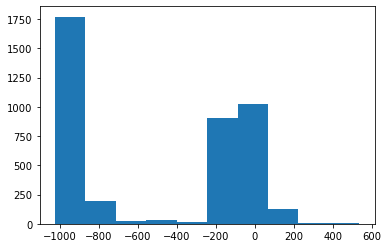

In [86]:
plt.hist(test_image_slices.flatten())

# TODO: Scale this: divide by 2000 

# Hounsfield unit are -2000-2000 so it's a nice number

(array([     0.,      0.,      0.,      0.,      0., 262144.,      0.,
             0.,      0.,      0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

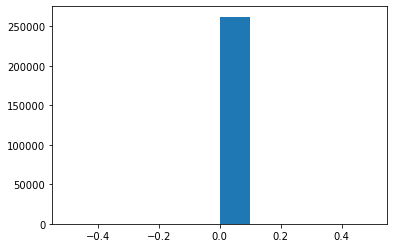

In [87]:
plt.hist(test_mask_slices.flatten())

# TODO: Find patch of mask with airway voxels. 

In [92]:
#model.fit(x=test_img, y=test_mask)
# model.fit(x=test_img[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:], y=test_mask[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:], epochs=100 ) # this is wrong lmao
model.fit(x=real_test_image_slices, y=real_test_mask_slices, epochs=1000 )

# TODO: add model checkpoint callback

Epoch 1/1000
1/1 [==============================] - 0s 319ms/step - loss: 0.3520
Epoch 2/1000
1/1 [==============================] - 0s 290ms/step - loss: 0.3492
Epoch 3/1000
1/1 [==============================] - 0s 287ms/step - loss: 0.3575
Epoch 4/1000
1/1 [==============================] - 0s 286ms/step - loss: 0.3489
Epoch 5/1000
1/1 [==============================] - 0s 287ms/step - loss: 0.3489
Epoch 6/1000
1/1 [==============================] - 0s 288ms/step - loss: 0.3536
Epoch 7/1000
1/1 [==============================] - 0s 288ms/step - loss: 0.3520
Epoch 8/1000
1/1 [==============================] - 0s 286ms/step - loss: 0.3530
Epoch 9/1000
1/1 [==============================] - 0s 287ms/step - loss: 0.3570
Epoch 10/1000
1/1 [==============================] - 0s 286ms/step - loss: 0.3481
Epoch 11/1000
1/1 [==============================] - 0s 287ms/step - loss: 0.3512
Epoch 12/1000
1/1 [==============================] - 0s 287ms/step - loss: 0.3477
Epoch 13/1000
1/1 [======

KeyboardInterrupt: 

In [94]:
# TODO configure prediction section
prediction = model.predict(real_test_image_slices)

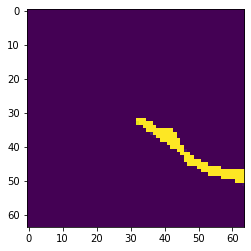

In [95]:
plt.imshow(prediction[0,:,:,32,0])

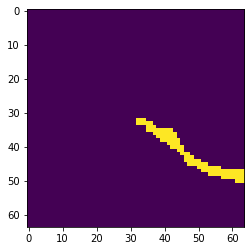

In [96]:
plt.imshow(real_test_mask_slices[0,:,:,32,0])

In [90]:
# plt.imshow(test_predict[(107-32):(107+32),(305-32):(305+32),(411-32):(411+32)])